In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib
import matplotlib.patches as mpatches
#import shap
import os
import pandas as pd

2024-08-16 13:37:46.002606: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-16 13:37:46.282429: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set matplotlib default color cycle
new_color_cycle = [
    '#1f77b4',
    '#ff7f0e',
    '#2ca02c',
    '#d62728',
    '#9467bd',
    '#8c564b',
    '#e377c2',
    '#7f7f7f',
    '#bcbd22',
    '#17becf',
    '#aec7e8',
    '#ffbb78',
    '#98df8a',
    '#ff9896',
    '#c5b0d5',
    '#c49c94',
    '#f7b6d2',
    '#c7c7c7',
    '#dbdb8d',
    '#9edae5'
]

# You can then apply this new color cycle to your matplotlib plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=new_color_cycle)

In [3]:
# This is the list that will hold all of the data (data22 and MC)

datasets = {}

## Collect Data

In [4]:
# Read MC data.

data_path = '/eos/home-m/mmcohen/ntuples/MC_07-17-2024/'

for filename in os.listdir(data_path):

    if filename.startswith('N') or filename.startswith('.'): continue

    dataset_tag = filename.split('_')[0]
    
    with h5py.File(data_path+filename, 'r') as hf:
        HLT_jets = hf['HLT_jets'][:]
        L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
        L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
        HLT_electrons = hf['HLT_electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        L1_egammas = hf['L1_egammas'][:]
        HLT_muons = hf['HLT_muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        L1_muons = hf['L1_muons'][:]
        L1_eFex_taus = hf['L1_eFex_taus'][:]
        L1_jFex_taus = hf['L1_jFex_taus'][:]
        HLT_photons = hf['HLT_photons'][:]
        HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
        pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
        pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]

        HLT_objects = np.concatenate([HLT_jets[:, :, [0, 2, 3]], HLT_electrons[:, :3, [0, 2, 3]], HLT_muons[:, :3, [0, 2, 3]], HLT_photons[:, :3, [0, 2, 3]], HLT_MET[:, :, [0, 2, 3]]], axis=1)
        L1_objects = np.concatenate([L1_jFexSR_jets[:, :, :], L1_egammas[:, :3, :], L1_muons[:, :3, :], L1_eFex_taus[:, :3, :], L1_MET], axis=1)
        
        datasets[dataset_tag] = {
            'HLT_data': HLT_objects,
            'L1_data': L1_objects,
            'passL1': pass_L1_unprescaled==1,
            'passHLT': pass_HLT_unprescaled==1,
            'weights': np.ones(len(HLT_objects)),
        }

        if len(HLT_objects) > 100000:
            datasets[dataset_tag] = {key: value[:100000] for key, value in datasets[dataset_tag].items()}

In [5]:
# Read 2024 EB data

with h5py.File('/eos/home-m/mmcohen/ntuples/EB_ntuples_08-13-2024.h5', 'r') as hf:
    HLT_jets = hf['HLT_jets'][:]
    ofl_jets = hf['ofl_jets'][:]
    L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
    L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
    HLT_electrons = hf['HLT_electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    ofl_electrons = hf['ofl_electrons'][:]
    L1_egammas = hf['L1_egammas'][:]
    HLT_muons = hf['HLT_muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    ofl_muons = hf['ofl_muons'][:]
    L1_muons = hf['L1_muons'][:]
    L1_eFex_taus = hf['L1_eFex_taus'][:]
    L1_jFex_taus = hf['L1_jFex_taus'][:]
    HLT_photons = hf['HLT_photons'][:]
    ofl_photons = hf['ofl_photons'][:]
    HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 3)  # Broadcasting MET
    L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]
    event_number = hf["event_number"][:]
    run_number = hf["run_number"][:]

HLT_objects = np.concatenate([HLT_jets[:, :, [0, 2, 3]], HLT_electrons[:, :3, :], HLT_muons[:, :3, :], HLT_photons[:, :3, :], HLT_MET], axis=1)
L1_objects = np.concatenate([L1_jFexSR_jets[:, :, :], L1_egammas[:, :3, :], L1_muons[:, :3, :], L1_eFex_taus[:, :3, :], L1_MET], axis=1)

datasets['473255_EB'] = {
    'HLT_data': HLT_objects,
    'L1_data': L1_objects,
    'passL1': pass_L1_unprescaled==1,
    'passHLT': pass_HLT_unprescaled==1,
    'weights': EB_weights,
    'event_numbers': event_number,
    'run_numbers': run_number
}

In [6]:
print(f"L1 Rate: {40000000 * (np.sum(datasets['473255_EB']['passL1'] * datasets['473255_EB']['weights']) / np.sum(datasets['473255_EB']['weights']))}")
print(f"HLT Rate: {100000 * (np.sum(datasets['473255_EB']['passHLT'] * datasets['473255_EB']['weights']) / np.sum(datasets['473255_EB']['passL1'] * datasets['473255_EB']['weights']))}")

L1 Rate: 76497.06502716217
HLT Rate: 1281.680931362244


In [7]:
for tag, dict in datasets.items():
    print(f'\n{tag}:')
    for key, value in dict.items():
        print(f'{key}: {value.shape}')


A14N23LO:
HLT_data: (10000, 20, 3)
L1_data: (10000, 20, 3)
passL1: (10000,)
passHLT: (10000,)
weights: (10000,)

HAHMggfZdZd2l2nu:
HLT_data: (70000, 20, 3)
L1_data: (70000, 20, 3)
passL1: (70000,)
passHLT: (70000,)
weights: (70000,)

HHbbttHadHad:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

ZZ4lep:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

Zprime2EJs:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ1:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ2:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ4:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

qqa:
HLT_data: (50000, 20, 3)
L1_data: (50000, 20, 3)
passL1: 

In [8]:
# In the EB sets, only take events that either passed L1

mask = datasets['473255_EB']['passL1']
for label, data in datasets['473255_EB'].items():
    datasets['473255_EB'][label] = data[mask]

In [9]:
# Zero out jets below 50GeV
for tag, dict in datasets.items():
    
    HLT_lowpt_mask = dict['HLT_data'][:, :10, 0] < 50
    dict['HLT_data'][:, :10][HLT_lowpt_mask] = 0

    
    L1_lowpt_mask = dict['L1_data'][:, :10, 0] < 50
    dict['L1_data'][:, :10][L1_lowpt_mask] = 0

In [10]:
# Change phi --> delta phi between leading jet
def dphi(phi1, phi2):
    return np.mod(phi1 - phi2 + np.pi, 2 * np.pi) - np.pi # accounts for periodicity of phi

for tag, dict in datasets.items():
    for data_type in ['HLT', 'L1']:

        # Create a mask for zeroed-out objects (where pt is zero)
        zeroed_mask = dict[data_type+'_data'][:, :, 0] == 0

        # Find phi of the leading jets in each event
        leading_jet_phi = dict[data_type+'_data'][:, 0, 2]

        # Duplicate along the third dimension such that it has the right shape
        leading_jet_phi = np.tile(leading_jet_phi, (20, 1)).T

        # update dphi for all objects
        dict[data_type+'_data'][:, :, 2] = dphi(phi1=dict[data_type+'_data'][:, :, 2], phi2=leading_jet_phi)

        # Reset phi of zeroed-out objects to zero
        dict[data_type+'_data'][zeroed_mask, 2] = 0

In [11]:
"""Multiply the et of the L1 muons by 1000 to get them into the right units."""
for tag, dict in datasets.items():
    for label, data in dict.items():
        if label == 'L1_data':
            data[:, 13:16, 0] *= 1000

In [12]:
"""Met bias. For some events, MET was not calculated, so was written as -999.
We don't want this to impact training, so we map 0 --> 0.001 and -999 --> 0"""
for tag, dict in datasets.items():
    for label, data in dict.items():
        if label.endswith('data'):

            # MET: 0 --> 0.001 and -999 --> 0 and nan --> 0
            MET_zeros = (data[:, 19, 0] == 0) # indices where MET=0
            MET_999 = ((data[:, 19, 0] == -999)) # indices where MET=-999 (not calculated)
            MET_nan = np.isnan(data[:, 19, 2])
            data[MET_zeros, 19, 0] = 0.001
            data[MET_999, 19, :] = 0
            data[MET_nan, 19, :] = 0

In [15]:
# Split EB data in train, test

random_seed = 789247

indices = np.arange(len(datasets['473255_EB']['HLT_data']))
train_indices, _indices = train_test_split(indices, train_size=0.5, random_state=random_seed)
test1_indices, test2_indices = train_test_split(_indices, train_size=0.5, random_state=random_seed)

datasets['EB_train'] = {key:value[train_indices] for key, value in datasets['473255_EB'].items()}
datasets['EB_test1'] = {key:value[test1_indices] for key, value in datasets['473255_EB'].items()}
datasets['EB_test2'] = {key:value[test2_indices] for key, value in datasets['473255_EB'].items()}

del datasets['473255_EB']

In [16]:
# """Normalize pt such that sum(pt) = 10 in each event"""
# for tag, dict in datasets.items():
#     for label, data in dict.items():
#         if label.endswith('data'):
#             # sum of the pt and E in each event
#             sum_pt = np.sum(data[:, :, 0], axis=1, keepdims=True)
        
#             # If the sum is 0, set the sum to 1 to avoid division by 0
#             sum_pt[sum_pt == 0] = 1
        
#             # Divide pt and E by their respective sums, multiply by 10
#             data[:, :, 0] *= (10/sum_pt)

In [18]:
# Scale the pts by dividing by the mean of the sample summed pts, and then multiplying by 5 to get the right OOM

# Calculate the mean over the training data
HLT_mean_sum_pts = np.mean(np.sum(datasets['EB_train']['HLT_data'][:, :, 0], axis=1))
L1_mean_sum_pts = np.mean(np.sum(datasets['EB_train']['L1_data'][:, :, 0], axis=1))

# Scale the pts of all the datasets
for tag, dict in datasets.items():
    dict['HLT_data'][:, :, 0] = 5 * dict['HLT_data'][:, :, 0] / HLT_mean_sum_pts
    dict['L1_data'][:, :, 0] = 5 * dict['L1_data'][:, :, 0] / L1_mean_sum_pts

In [20]:
# Flatten ndarrays for use in DNN

for tag, dict in datasets.items():
    for label, data in dict.items():
        if label.endswith('data'):
            datasets[tag][label] = np.reshape(data, newshape=(-1, 60))

# Display the structure of updated datasets
for tag, data in datasets.items():
    print(f'\n{tag}:')
    for key, value in data.items():
        print(f'{key}: {value.shape}')


A14N23LO:
HLT_data: (10000, 60)
L1_data: (10000, 60)
passL1: (10000,)
passHLT: (10000,)
weights: (10000,)

HAHMggfZdZd2l2nu:
HLT_data: (70000, 60)
L1_data: (70000, 60)
passL1: (70000,)
passHLT: (70000,)
weights: (70000,)

HHbbttHadHad:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

ZZ4lep:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

Zprime2EJs:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ1:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ2:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ4:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

qqa:
HLT_data: (50000, 60)
L1_data: (50000, 60)
passL1: (50000,)
passHLT: (50000,)
weights: (50000,)

EB_train

## Network Infrastructure

In [21]:
# Default network architecture
def create_AE(input_dim, h_dim_1, h_dim_2, latent_dim):
    
     # Encoder
    encoder_inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(h_dim_1, activation='relu')(encoder_inputs)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    z = layers.Dense(latent_dim, activation='relu')(x)
    
    encoder = Model(inputs=encoder_inputs, outputs=z)

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(h_dim_2, activation='relu')(decoder_inputs)
    x = layers.Dense(h_dim_1, activation='relu')(x)
    outputs = layers.Dense(input_dim)(x)

    decoder = Model(inputs=decoder_inputs, outputs=outputs)

    ae_outputs = decoder(encoder(encoder_inputs))
    ae = Model(encoder_inputs, outputs=ae_outputs)

    return ae, encoder, decoder

In [22]:
# Larger network
# def create_AE(input_dim, h_dim_1, h_dim_2, h_dim_3, h_dim_4, latent_dim):
    
#      # Encoder
#     encoder_inputs = layers.Input(shape=(input_dim,))
#     x = layers.Dense(h_dim_1, activation='relu')(encoder_inputs)
#     x = layers.Dense(h_dim_2, activation='relu')(x)
#     x = layers.Dense(h_dim_3, activation='relu')(x)
#     x = layers.Dense(h_dim_4, activation='relu')(x)
#     z = layers.Dense(latent_dim, activation='relu')(x)
    
#     encoder = Model(inputs=encoder_inputs, outputs=z)

#     # Decoder
#     decoder_inputs = layers.Input(shape=(latent_dim,))
#     x = layers.Dense(h_dim_4, activation='relu')(decoder_inputs)
#     x = layers.Dense(h_dim_3, activation='relu')(x)
#     x = layers.Dense(h_dim_2, activation='relu')(x)
#     x = layers.Dense(h_dim_1, activation='relu')(x)
#     outputs = layers.Dense(input_dim)(x)

#     decoder = Model(inputs=decoder_inputs, outputs=outputs)

#     ae_outputs = decoder(encoder(encoder_inputs))
#     ae = Model(encoder_inputs, outputs=ae_outputs)

#     return ae, encoder, decoder

In [23]:
# With regularizers
# from tensorflow.keras import regularizers
# def create_AE(input_dim, h_dim_1, h_dim_2, latent_dim, l2_reg=0.01):
    
#     # Encoder
#     encoder_inputs = layers.Input(shape=(input_dim,))
#     x = layers.Dense(h_dim_1, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(encoder_inputs)
#     x = layers.Dense(h_dim_2, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
#     z = layers.Dense(latent_dim, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    
#     encoder = Model(inputs=encoder_inputs, outputs=z)

#     # Decoder
#     decoder_inputs = layers.Input(shape=(latent_dim,))
#     x = layers.Dense(h_dim_2, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(decoder_inputs)
#     x = layers.Dense(h_dim_1, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
#     outputs = layers.Dense(input_dim, kernel_regularizer=regularizers.l2(l2_reg))(x)

#     decoder = Model(inputs=decoder_inputs, outputs=outputs)

#     ae_outputs = decoder(encoder(encoder_inputs))
#     ae = Model(encoder_inputs, outputs=ae_outputs)

#     return ae, encoder, decoder

In [24]:
def loss_fn(y_true, y_pred):
    # mask0 = K.cast(K.not_equal(y_true, 0), K.floatx())
    # maskMET = K.cast(K.not_equal(y_true, -999), K.floatx())
    # mask = mask0 * maskMET
    # squared_difference = K.square(mask * (y_pred - y_true))
    squared_difference = K.square((y_pred - y_true))
    return K.mean(squared_difference)

## Train

In [26]:
# Define parameters
INPUT_DIM = datasets['EB_train']['HLT_data'].shape[1]
H_DIM_1 = 32
H_DIM_2 = 8
LATENT_DIM = 3

HLT_AE, HLT_encoder, HLT_decoder = create_AE(INPUT_DIM, H_DIM_1, H_DIM_2, LATENT_DIM)
L1_AE, L1_encoder, L1_decoder = create_AE(INPUT_DIM, H_DIM_1, H_DIM_2, LATENT_DIM)

HLT_AE.summary()
L1_AE.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 60)]              0         
                                                                 
 model_6 (Functional)        (None, 3)                 2243      
                                                                 
 model_7 (Functional)        (None, 60)                2300      
                                                                 
Total params: 4543 (17.75 KB)
Trainable params: 4543 (17.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 60)]              0         
                                                                 
 model_

In [27]:
# # Initialize models
# INPUT_DIM = datasets['EB_train']['HLT_data'].shape[1]
# H_DIM_1 = 100
# H_DIM_2 = 100
# H_DIM_3 = 64
# H_DIM_4 = 32
# LATENT_DIM = 6

# HLT_AE, HLT_encoder, HLT_decoder = create_AE(INPUT_DIM, H_DIM_1, H_DIM_2, H_DIM_3, H_DIM_4, LATENT_DIM)
# L1_AE, L1_encoder, L1_decoder = create_AE(INPUT_DIM, H_DIM_1, H_DIM_2, H_DIM_3, H_DIM_4, LATENT_DIM)

# HLT_AE.summary()
# L1_AE.summary()

In [28]:
HLT_AE.compile(optimizer='adam', loss=loss_fn)
L1_AE.compile(optimizer='adam', loss=loss_fn)

In [29]:
# Define callbacks: early stopping and learning rate scheduler

STOP_PATIENCE = 6
LR_PATIENCE = 4

early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]

In [30]:
NUM_EPOCHS = 200
BATCH_SIZE = 512

In [31]:
# train HLT model
history = HLT_AE.fit(
    x=datasets['EB_train']['HLT_data'], 
    y=datasets['EB_train']['HLT_data'], 
    validation_split=0.15, 
    epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    callbacks=callbacks, 
    sample_weight = datasets['EB_train']['weights']
)

Epoch 1/200


2024-08-16 13:40:25.692334: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3bf59c58c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-16 13:40:25.692397: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-16 13:40:25.707371: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-16 13:40:25.745935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-08-16 13:40:25.977279: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


501/501 [==============================] - 6s 5ms/step - loss: 933.1311 - val_loss: 419.6710 - lr: 0.0010
Epoch 2/200
501/501 [==============================] - 2s 4ms/step - loss: 763.3586 - val_loss: 396.2257 - lr: 0.0010
Epoch 3/200
501/501 [==============================] - 2s 4ms/step - loss: 809.2086 - val_loss: 365.2284 - lr: 0.0010
Epoch 4/200
501/501 [==============================] - 2s 4ms/step - loss: 731.5481 - val_loss: 359.0506 - lr: 0.0010
Epoch 5/200
501/501 [==============================] - 2s 4ms/step - loss: 657.4183 - val_loss: 358.0163 - lr: 0.0010
Epoch 6/200
501/501 [==============================] - 2s 4ms/step - loss: 713.4343 - val_loss: 350.8849 - lr: 0.0010
Epoch 7/200
501/501 [==============================] - 2s 4ms/step - loss: 724.0225 - val_loss: 358.9586 - lr: 0.0010
Epoch 8/200
501/501 [==============================] - 2s 4ms/step - loss: 688.3634 - val_loss: 346.8667 - lr: 0.0010
Epoch 9/200
501/501 [==============================] - 2s 4ms/step -

In [32]:
HLT_AE.save_weights('./trained_models/EB_HLT_tests3.keras')
HLT_encoder.save_weights('./trained_models/EB_HLT_encoder_tests3.keras')

In [33]:
HLT_AE.load_weights('./trained_models/EB_HLT_tests3.keras')
HLT_encoder.load_weights('./trained_models/EB_HLT_encoder_tests3.keras')

In [34]:
# train L1 model
# train HLT model
history = L1_AE.fit(
    x=datasets['EB_train']['L1_data'], 
    y=datasets['EB_train']['L1_data'], 
    validation_split=0.15, 
    epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    callbacks=callbacks, 
    sample_weight = datasets['EB_train']['weights']
)

Epoch 1/200
501/501 [==============================] - 5s 5ms/step - loss: 507.1698 - val_loss: 391.7322 - lr: 0.0010
Epoch 2/200
501/501 [==============================] - 2s 4ms/step - loss: 405.1184 - val_loss: 363.1319 - lr: 0.0010
Epoch 3/200
501/501 [==============================] - 2s 4ms/step - loss: 384.8372 - val_loss: 349.3052 - lr: 0.0010
Epoch 4/200
501/501 [==============================] - 2s 4ms/step - loss: 370.7466 - val_loss: 336.4612 - lr: 0.0010
Epoch 5/200
501/501 [==============================] - 2s 4ms/step - loss: 360.4288 - val_loss: 329.5476 - lr: 0.0010
Epoch 6/200
501/501 [==============================] - 2s 4ms/step - loss: 352.8542 - val_loss: 325.1751 - lr: 0.0010
Epoch 7/200
501/501 [==============================] - 2s 4ms/step - loss: 348.8362 - val_loss: 321.9437 - lr: 0.0010
Epoch 8/200
501/501 [==============================] - 2s 4ms/step - loss: 346.3272 - val_loss: 319.3758 - lr: 0.0010
Epoch 9/200
501/501 [==============================] - 2

In [35]:
L1_AE.save_weights('./trained_models/EB_L1_tests3.keras')
L1_encoder.save_weights('./trained_models/EB_L1_encoder_tests3.keras')

In [36]:
L1_AE.load_weights('./trained_models/EB_L1_tests3.keras')
L1_encoder.load_weights('./trained_models/EB_L1_encoder_tests3.keras')

# Evaluate Model

## Normal Eval

In [37]:
# Pass the datasets through the model

for tag, dict in datasets.items():
    if tag == 'EB_train': continue

    dict['HLT_model_outputs'] = HLT_AE.predict(dict['HLT_data'])
    #dict['HLT_latent_reps'] = HLT_encoder.predict(dict['HLT_data'])
    dict['L1_model_outputs'] = L1_AE.predict(dict['L1_data'])
    #dict['L1_latent_reps'] = L1_encoder.predict(dict['L1_data'])

4715/4715 [==============================] - 8s 2ms/step


In [38]:
def mse_loss(true, prediction):
    loss = np.mean(np.square(true - prediction), axis=-1)
    return loss

In [39]:
def MSE_AD_score(y, x):
    # masked mse
    mask = (y != 0) & (y != -999)
    _x = x * mask
    _y = y * mask
    # return (mse_loss(_y, _x))
    return (mse_loss(y, x))

In [40]:
# Calculate the AD scores

for tag, dict in datasets.items():
    if tag == 'EB_train': continue

    dict['HLT_AD_scores'] = MSE_AD_score(dict['HLT_data'], dict['HLT_model_outputs'])
    dict['L1_AD_scores'] = MSE_AD_score(dict['L1_data'], dict['L1_model_outputs'])

In [41]:
# Display the structure of updated datasets
for tag, data in datasets.items():
    print(f'\n{tag}:')
    for key, value in data.items():
        print(f'{key}: {value.shape}')


A14N23LO:
HLT_data: (10000, 60)
L1_data: (10000, 60)
passL1: (10000,)
passHLT: (10000,)
weights: (10000,)
HLT_model_outputs: (10000, 60)
L1_model_outputs: (10000, 60)
HLT_AD_scores: (10000,)
L1_AD_scores: (10000,)

HAHMggfZdZd2l2nu:
HLT_data: (70000, 60)
L1_data: (70000, 60)
passL1: (70000,)
passHLT: (70000,)
weights: (70000,)
HLT_model_outputs: (70000, 60)
L1_model_outputs: (70000, 60)
HLT_AD_scores: (70000,)
L1_AD_scores: (70000,)

HHbbttHadHad:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)
HLT_model_outputs: (100000, 60)
L1_model_outputs: (100000, 60)
HLT_AD_scores: (100000,)
L1_AD_scores: (100000,)

ZZ4lep:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)
HLT_model_outputs: (100000, 60)
L1_model_outputs: (100000, 60)
HLT_AD_scores: (100000,)
L1_AD_scores: (100000,)

Zprime2EJs:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,

In [42]:
def ROC_curve(dataset, bkg_type, target_rate=10, plot=True):
    """
    Plots ROC curve and returns AUC, TPR, FPR, and thresholds for each dataset.
    
    inputs: 
    dataset: dictionary containing dataset information
    bkg_type: the background type to calculate over
    plot: whether to plot the ROC curve or not
    
    returns:
    results: dictionary {dataset_names: {'TPR': ..., 'AUC': ..., 'FPR': ..., 'threshold': ...}}
    """
    
    bkg_tag = 'EB_test1'
    #target_rate = 10  # 10 Hz pure rate
    plt.figure(figsize=(8.5,6.8))
    
    results = {}
    
    for tag in dataset.keys():
        if tag != bkg_tag and tag != 'EB_train':
        
            # Combine true labels, anomaly=1 and background=0
            trueVal = np.concatenate((np.ones(dataset[tag][f'{bkg_type}_AD_scores'].shape[0]), np.zeros(dataset[bkg_tag][f'{bkg_type}_AD_scores'].shape[0])))
            
            # Combine predictions from current dataset and background
            predVal_loss = np.concatenate((dataset[tag][f'{bkg_type}_AD_scores'], dataset[bkg_tag][f'{bkg_type}_AD_scores']))
        
            sample_weights = np.concatenate((dataset[tag]['weights'], dataset[bkg_tag]['weights']))
        
            # Calculate ROC curve and AUC, including weights
            fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
            auc_loss = auc(fpr_loss, tpr_loss)

            # Initialize variables for early stopping
            min_diff = float('inf')
            best_idx = 0
            previous_diff = float('inf')
            
            # Iterate over thresholds with early stopping
            for idx, value in enumerate(threshold_loss):
                anomaly_idxs_bkg = dataset[bkg_tag][f'{bkg_type}_AD_scores'] > value
                bkg_rate = 100000 * np.sum(dataset[bkg_tag]['weights'] * (anomaly_idxs_bkg & ~dataset[bkg_tag]['passHLT'])) / np.sum(dataset[bkg_tag]['weights'])
                # Calculate the difference from the target rate
                diff = abs(bkg_rate - target_rate)
                
                # Check if the difference is decreasing
                if diff < min_diff:
                    min_diff = diff
                    best_idx = idx
                else:
                    # If the difference starts increasing, break the loop
                    if diff > previous_diff:
                        print(f'Background rate = {bkg_rate:.3}Hz')
                        break
                
                previous_diff = diff
            
            # Use the best index found
            selected_threshold = threshold_loss[best_idx]
            selected_fpr = fpr_loss[best_idx]
            signal_tpr = tpr_loss[best_idx]
            
            # Store the results
            results[tag] = {
                'TPR': signal_tpr,
                'AUC': auc_loss,
                'FPR': selected_fpr,
                'threshold': selected_threshold
            }
        
            # Plot ROC curve
            if plot:
                plt.plot(fpr_loss, tpr_loss, "-", label='%s (AUC = %.1f%%)' % (tag, auc_loss*100.), linewidth=1.5)

    if plot:
        # Set log scale for x and y axis
        plt.semilogx()
        plt.semilogy()
        
        # Plot aesthetics and layout
        plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
        plt.plot([selected_fpr, selected_fpr], [0, 1], '--', color='r')
        plt.ylabel("True Positive Rate", fontsize=16)
        plt.xlabel("False Positive Rate", fontsize=16)
        plt.legend(loc='lower right', fontsize=13)
        plt.grid(True)
        plt.tight_layout()
        plt.title(f'Trained over {bkg_type} objects', fontsize=20)
        plt.show()

    return results


In [44]:
def ROC_curve_3(dataset, bkg_type, plot=True):
    """
    Plots TPR vs Pure rate
    """
    
    bkg_tag = 'EB_test1'
    plt.figure(figsize=(8.5,6.8))
    
    results = {}

    # Compute the pure rates for the background only once
    pure_rates = []
    threshold_loss_bkg = None
    
    # Calculate ROC curve and AUC for the background
    predVal_bkg = dataset[bkg_tag][f'{bkg_type}_AD_scores']
    sample_weights_bkg = dataset[bkg_tag]['weights']
    trueVal_bkg = np.zeros(predVal_bkg.shape[0])  # Background is labeled as 0
    
    # ROC curve for the background
    fpr_loss_bkg, tpr_loss_bkg, threshold_loss_bkg = roc_curve(y_true=trueVal_bkg, y_score=predVal_bkg, sample_weight=sample_weights_bkg)
    
    for idx, value in enumerate(threshold_loss_bkg):
        anomaly_idxs_bkg = predVal_bkg > value
        bkg_rate = 100000 * np.sum(sample_weights_bkg * (anomaly_idxs_bkg & ~dataset[bkg_tag]['passHLT'])) / np.sum(sample_weights_bkg)
        pure_rates.append(bkg_rate)

    # Iterate over each signal dataset and use the precomputed pure rates for plotting
    for tag in dataset.keys():
        if tag != bkg_tag and tag != 'EB_train':
            predVal_signal = dataset[tag][f'{bkg_type}_AD_scores']
            sample_weights_signal = dataset[tag]['weights']
            trueVal_signal = np.ones(predVal_signal.shape[0])  # Signal is labeled as 1

            # Combine signal and background true labels and predictions
            trueVal = np.concatenate((trueVal_signal, trueVal_bkg))
            predVal_loss = np.concatenate((predVal_signal, predVal_bkg))
            sample_weights = np.concatenate((sample_weights_signal, sample_weights_bkg))

            # Calculate ROC curve and AUC for the current signal, including weights
            fpr_loss_signal, tpr_loss_signal, threshold_loss_signal = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
            auc_loss = auc(fpr_loss_signal, tpr_loss_signal)
            
            # Interpolate TPR values at the background's thresholds using np.interp
            aligned_tpr_signal = np.interp(threshold_loss_bkg, threshold_loss_signal[::-1], tpr_loss_signal[::-1])

            # Plot ROC curve with pure rate on the x-axis
            if plot:
                plt.plot(pure_rates, aligned_tpr_signal, "-", label='%s (AUC = %.1f%%)' % (tag, auc_loss*100.), linewidth=1.5)

    if plot:
        # Set log scale for x and y axis
        plt.semilogx()
        plt.semilogy()
        
        # Plot aesthetics and layout
        xx = np.linspace(0, max(pure_rates), 10)
        yy = np.linspace(0, 1, 10)  # Since TPR and FPR should be proportional in random guessing
        plt.plot(xx, yy, '--', color='0.75')
        plt.plot(pure_rates, tpr_loss_bkg, '--', color='0.75')
        plt.ylabel("True Positive Rate", fontsize=16)
        plt.xlabel("Pure Rate (Hz)", fontsize=16)
        plt.legend(loc='lower right', fontsize=13)
        plt.grid(True)
        plt.tight_layout()
        plt.title(f'Trained over {bkg_type} objects', fontsize=20)
        plt.show()

    #return results

### ptsum division normalization, default network size (tests3)

TARGET (PURE) RATE::::: 10
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz


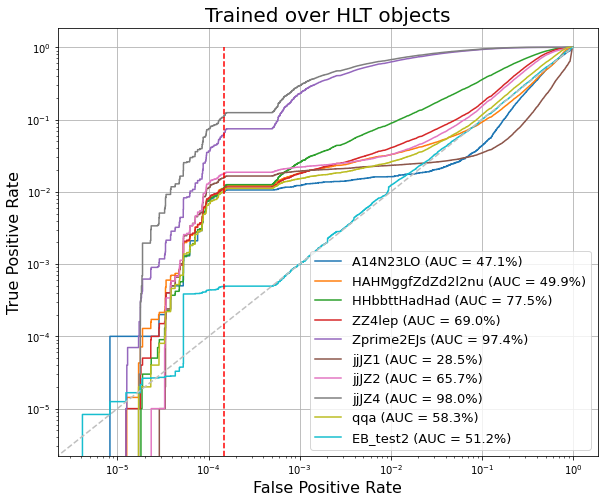

Background rate = 10.6Hz
Background rate = 10.6Hz
Background rate = 10.6Hz
Background rate = 10.6Hz
Background rate = 10.6Hz
Background rate = 10.6Hz
Background rate = 10.6Hz
Background rate = 10.6Hz
Background rate = 10.6Hz
Background rate = 10.6Hz


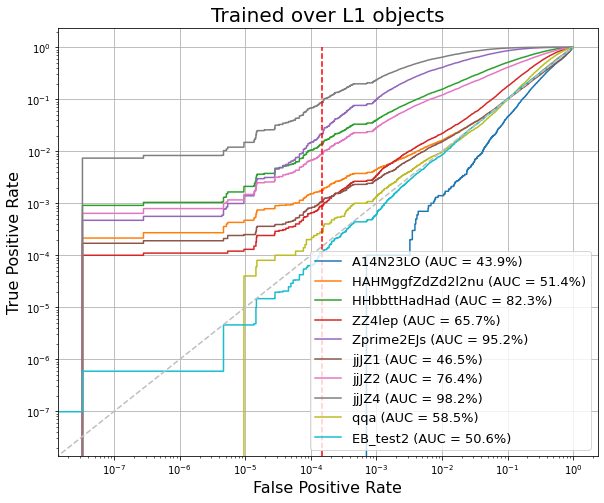

Normalized by the left bar:
[1.         1.00004166 1.00437066 1.00009188 1.00040868 1.46759259
 1.77310924 1.00118099 1.00198632 1.00773643]


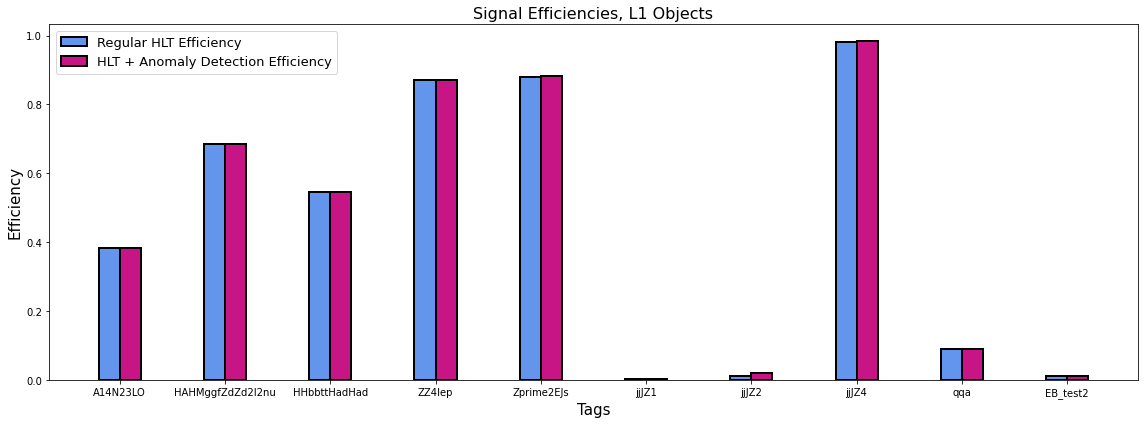

Normalized by the left bar:
[1.         1.00004166 1.00279135 1.00003445 1.00024975 1.31018519
 1.51353875 1.0009061  1.00176561 1.00386329]


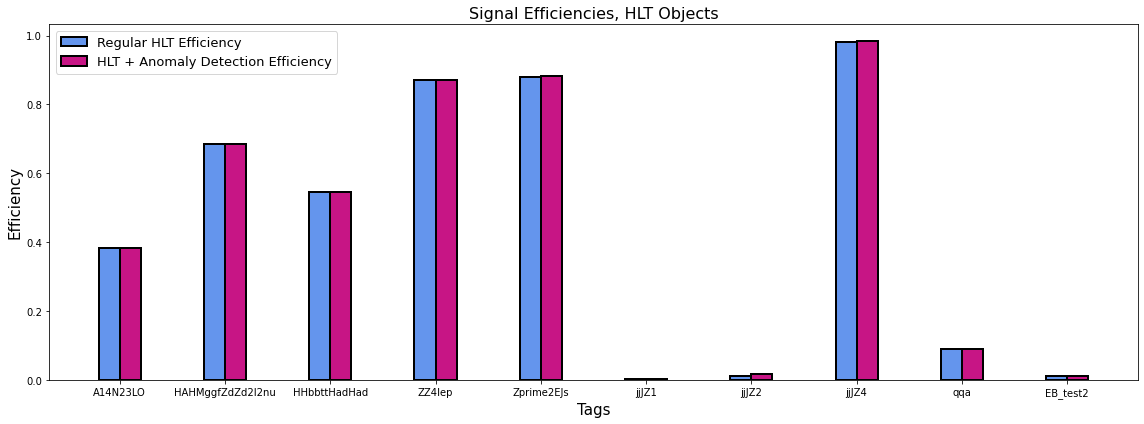

-----
A14N23LO:
HLT overlap: 0.4387755102040816
inverse overlap: 1.0143229166666667
Weighted percentage of events that passed some HLT trigger: 0.384
Weighted percentage of events that we tagged as anomalous: 0.0098
Raw number of events that we tagged as anomalous: 98
Raw number of events that passed some HLT trigger: 3840
Raw number of events that we tagged as anomalous and passed some HLT trigger: 43
-----
HAHMggfZdZd2l2nu:
HLT overlap: 0.8251928020565553
inverse overlap: 1.0028332152826966
Weighted percentage of events that passed some HLT trigger: 0.6857428571428571
Weighted percentage of events that we tagged as anomalous: 0.011114285714285714
Raw number of events that we tagged as anomalous: 778
Raw number of events that passed some HLT trigger: 48002
Raw number of events that we tagged as anomalous and passed some HLT trigger: 642
-----
HHbbttHadHad:
HLT overlap: 0.8827838827838828
inverse overlap: 1.0023506078524993
Weighted percentage of events that passed some HLT trigger: 0.

/tmp/ipykernel_347/2208538036.py:155: RuntimeWarning: invalid value encountered in double_scalars
  HLT_overlap = np.sum(datasets[tag]['weights'] * (HLT_anomaly_idxs & datasets[tag]['passHLT'])) / np.sum(datasets[tag]['weights'] * HLT_anomaly_idxs)


Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz


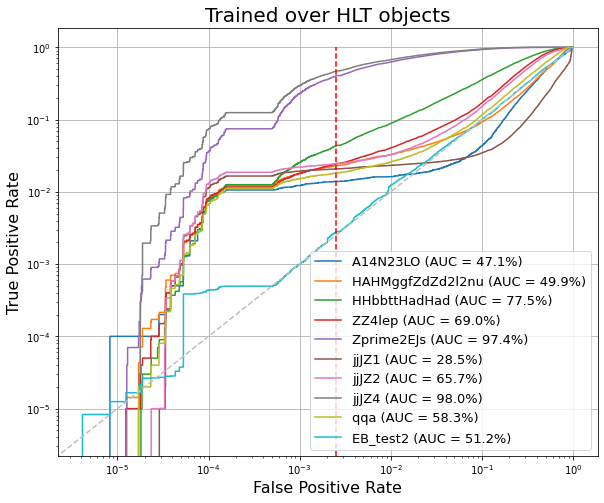

Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz


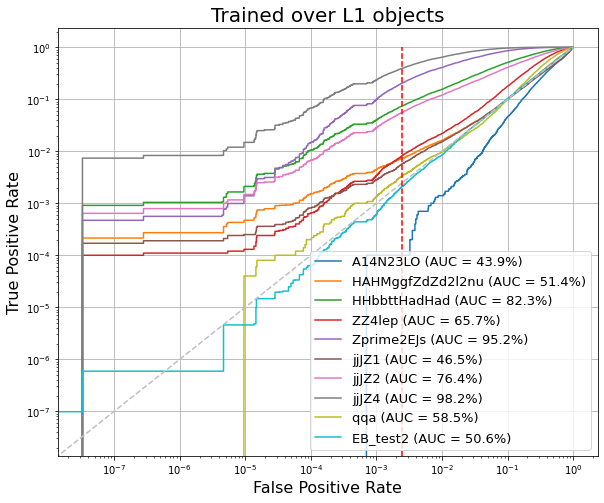

Normalized by the left bar:
[1.00026042 1.00037498 1.02670144 1.00073502 1.00539233 3.54166667
 6.01867414 1.00540607 1.01831825 1.13091252]


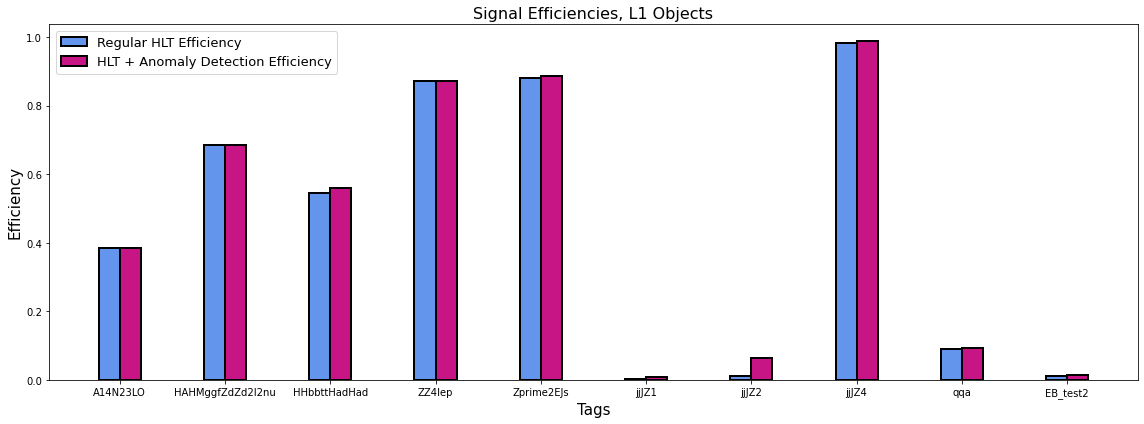

Normalized by the left bar:
[1.00026042 1.00024999 1.01893341 1.00053978 1.00326946 2.75
 4.61344538 1.00429635 1.0121386  1.07113217]


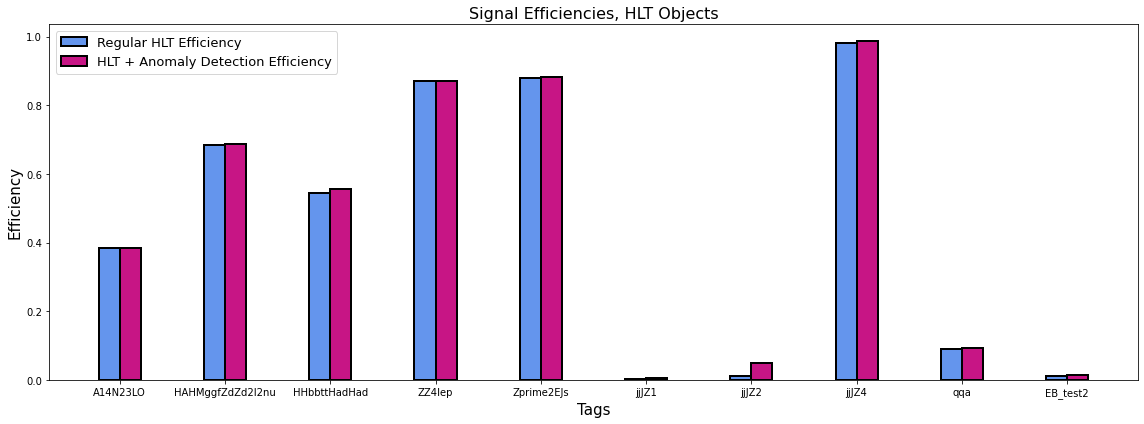

-----
A14N23LO:
HLT overlap: 0.4316546762589928
inverse overlap: 1.0205729166666666
Weighted percentage of events that passed some HLT trigger: 0.384
Weighted percentage of events that we tagged as anomalous: 0.0139
Raw number of events that we tagged as anomalous: 139
Raw number of events that passed some HLT trigger: 3840
Raw number of events that we tagged as anomalous and passed some HLT trigger: 60
-----
HAHMggfZdZd2l2nu:
HLT overlap: 0.8564386937769563
inverse overlap: 1.0048539644181493
Weighted percentage of events that passed some HLT trigger: 0.6857428571428571
Weighted percentage of events that we tagged as anomalous: 0.023185714285714285
Raw number of events that we tagged as anomalous: 1623
Raw number of events that passed some HLT trigger: 48002
Raw number of events that we tagged as anomalous and passed some HLT trigger: 1390
-----
HHbbttHadHad:
HLT overlap: 0.9198167239404352
inverse overlap: 1.006427443346678
Weighted percentage of events that passed some HLT trigger: 

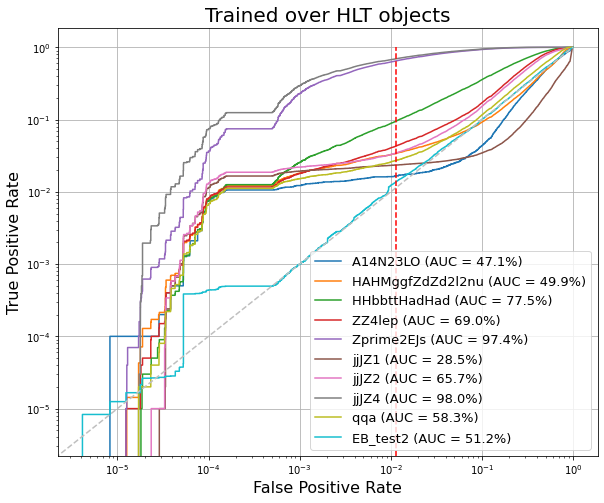

Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz


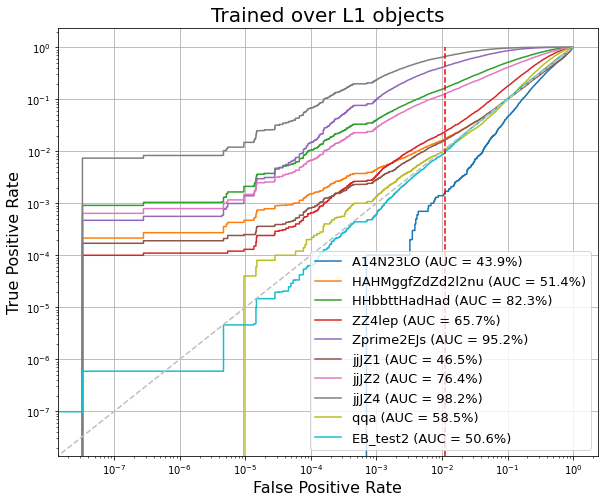

Normalized by the left bar:
[ 1.00182292  1.00170826  1.07097734  1.00207872  1.02148987  8.48611111
 12.64612512  1.00991621  1.06157581  1.68345917]


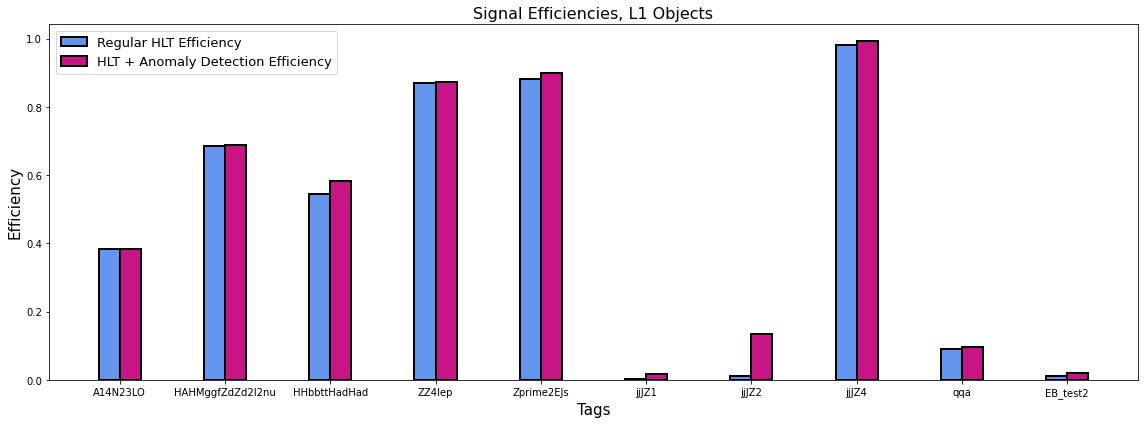

Normalized by the left bar:
[1.00104167 1.00087496 1.04928931 1.00127479 1.01335029 6.00462963
 9.64799253 1.00795129 1.03950563 1.35876621]


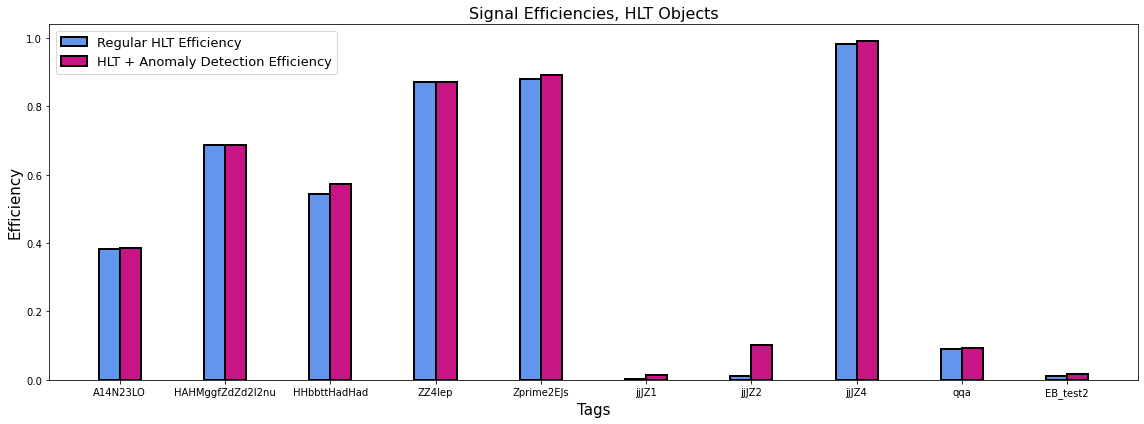

-----
A14N23LO:
HLT overlap: 0.463855421686747
inverse overlap: 1.0231770833333333
Weighted percentage of events that passed some HLT trigger: 0.384
Weighted percentage of events that we tagged as anomalous: 0.0166
Raw number of events that we tagged as anomalous: 166
Raw number of events that passed some HLT trigger: 3840
Raw number of events that we tagged as anomalous and passed some HLT trigger: 77
-----
HAHMggfZdZd2l2nu:
HLT overlap: 0.8768971332209107
inverse overlap: 1.006083079871672
Weighted percentage of events that passed some HLT trigger: 0.6857428571428571
Weighted percentage of events that we tagged as anomalous: 0.03388571428571428
Raw number of events that we tagged as anomalous: 2372
Raw number of events that passed some HLT trigger: 48002
Raw number of events that we tagged as anomalous and passed some HLT trigger: 2080
-----
HHbbttHadHad:
HLT overlap: 0.8848311633322749
inverse overlap: 1.0199801667462445
Weighted percentage of events that passed some HLT trigger: 0.

In [46]:
for target_rate in [10, 200, 1000]:
    print(f'TARGET (PURE) RATE::::: {target_rate}')
    HLT_results = ROC_curve(datasets, bkg_type='HLT', target_rate=target_rate)
    L1_results = ROC_curve(datasets, bkg_type='L1', target_rate=target_rate)

    # L1 Signal Efficiencies

    tags = []
    l1_efficiencies = []
    combined_efficiencies = []
    
    skip_tags = ['EB_train', 'EB_test1']
    for tag, dict in datasets.items():
        if tag in skip_tags: 
            continue
    
        # Extract HLT and L1 results from the respective dictionaries
        hlt_result = HLT_results.get(tag)
        l1_result = L1_results.get(tag)
        
        if hlt_result and l1_result:
            # Extract TPR for regular HLT efficiency
            #HLT_TPR = hlt_result['TPR']
            L1_TPR = np.sum(dict['passHLT'] * dict['weights']) / np.sum(dict['weights'])
            
            # Calculate the combined efficiency (HLT + Anomaly Detection)
            L1_anomaly_idxs = datasets[tag]['L1_AD_scores'] > L1_results[tag]['threshold']
            L1_or_anom_TPR = np.sum((datasets[tag]['passHLT'] | L1_anomaly_idxs) * datasets[tag]['weights']) / np.sum(datasets[tag]['weights'])
            
            tags.append(tag)
            l1_efficiencies.append(L1_TPR)
            combined_efficiencies.append(L1_or_anom_TPR)
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot regular HLT efficiency
    bar_width = 0.2
    index = np.arange(len(tags))
    bar1 = ax.bar(index, l1_efficiencies, bar_width, label='Regular HLT Efficiency', color='cornflowerblue', edgecolor='k', linewidth=2)
    
    # Plot combined efficiency (HLT + Anomaly Detection)
    bar2 = ax.bar(index + bar_width, combined_efficiencies, bar_width, label='HLT + Anomaly Detection Efficiency', color='mediumvioletred', edgecolor='k', linewidth=2)
    print(f'Normalized by the left bar:\n{np.array(combined_efficiencies) / np.array(l1_efficiencies)}')
    # Add labels and title
    ax.set_xlabel('Tags', fontsize=15)
    ax.set_ylabel('Efficiency', fontsize=15)
    ax.set_title('Signal Efficiencies, L1 Objects', fontsize=16)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(tags)
    #ax.set_yscale('log')
    ax.legend(fontsize=13)
    
    plt.tight_layout()
    plt.show()



    # Signal Efficiencies

    tags = []
    hlt_efficiencies = []
    combined_efficiencies = []
    
    skip_tags = ['EB_train', 'EB_test1']
    for tag, dict in datasets.items():
        if tag in skip_tags: 
            continue
    
        # Extract HLT and L1 results from the respective dictionaries
        hlt_result = HLT_results.get(tag)
        l1_result = L1_results.get(tag)
        
        if hlt_result and l1_result:
            # Extract TPR for regular HLT efficiency
            #HLT_TPR = hlt_result['TPR']
            HLT_TPR = np.sum(dict['passHLT'] * dict['weights']) / np.sum(dict['weights'])
            
            # Calculate the combined efficiency (HLT + Anomaly Detection)
            HLT_anomaly_idxs = datasets[tag]['L1_AD_scores'] > HLT_results[tag]['threshold']
            HLT_or_anom_TPR = np.sum((datasets[tag]['passHLT'] | HLT_anomaly_idxs) * datasets[tag]['weights']) / np.sum(datasets[tag]['weights'])
            
            tags.append(tag)
            hlt_efficiencies.append(HLT_TPR)
            combined_efficiencies.append(HLT_or_anom_TPR)
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot regular HLT efficiency
    bar_width = 0.2
    index = np.arange(len(tags))
    bar1 = ax.bar(index, hlt_efficiencies, bar_width, label='Regular HLT Efficiency', color='cornflowerblue', edgecolor='k', linewidth=2)
    
    # Plot combined efficiency (HLT + Anomaly Detection)
    bar2 = ax.bar(index + bar_width, combined_efficiencies, bar_width, label='HLT + Anomaly Detection Efficiency', color='mediumvioletred', edgecolor='k', linewidth=2)
    print(f'Normalized by the left bar:\n{np.array(combined_efficiencies) / np.array(hlt_efficiencies)}')
    # Add labels and title
    ax.set_xlabel('Tags', fontsize=15)
    ax.set_ylabel('Efficiency', fontsize=15)
    ax.set_title('Signal Efficiencies, HLT Objects', fontsize=16)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(tags)
    #ax.set_yscale('log')
    ax.legend(fontsize=13)
    
    plt.tight_layout()
    plt.show()
    
    # HLT overlaps
    skip_tags = ['EB_train', 'EB_test1']
    for tag in datasets.keys():
        if tag in skip_tags:
            continue
    
        # Extract relevant information from the results dictionaries
        hlt_result = HLT_results.get(tag)
        
        if hlt_result:
            HLT_threshold = hlt_result['threshold']
            
            # Calculate HLT anomaly indices based on the threshold
            HLT_anomaly_idxs = datasets[tag]['HLT_AD_scores'] > HLT_threshold
    
            # Calculate overlaps
            HLT_overlap = np.sum(datasets[tag]['weights'] * (HLT_anomaly_idxs & datasets[tag]['passHLT'])) / np.sum(datasets[tag]['weights'] * HLT_anomaly_idxs)
            inverse_overlap = np.sum(datasets[tag]['weights'] * (HLT_anomaly_idxs | datasets[tag]['passHLT'])) / np.sum(datasets[tag]['weights'] * datasets[tag]['passHLT'])
    
            # Print the results
            print(f'-----\n{tag}:')
            print(f'HLT overlap: {HLT_overlap}')
            print(f'inverse overlap: {inverse_overlap}')
            print(f"Weighted percentage of events that passed some HLT trigger: {np.sum(datasets[tag]['passHLT']) / len(datasets[tag]['passHLT'])}")
            print(f"Weighted percentage of events that we tagged as anomalous: {np.sum(HLT_anomaly_idxs) / len(HLT_anomaly_idxs)}")
            print(f'Raw number of events that we tagged as anomalous: {np.sum(HLT_anomaly_idxs)}')
            print(f"Raw number of events that passed some HLT trigger: {np.sum(datasets[tag]['passHLT'])}")
            print(f"Raw number of events that we tagged as anomalous and passed some HLT trigger: {np.sum(HLT_anomaly_idxs * datasets[tag]['passHLT'])}")

    # HLT overlaps
    skip_tags = ['EB_train', 'EB_test1']
    for tag in datasets.keys():
        if tag in skip_tags:
            continue
    
        # Extract relevant information from the results dictionaries
        hlt_result = L1_results.get(tag)
        
        if hlt_result:
            HLT_threshold = hlt_result['threshold']
            
            # Calculate HLT anomaly indices based on the threshold
            HLT_anomaly_idxs = datasets[tag]['L1_AD_scores'] > HLT_threshold
    
            # Calculate overlaps
            HLT_overlap = np.sum(datasets[tag]['weights'] * (HLT_anomaly_idxs & datasets[tag]['passHLT'])) / np.sum(datasets[tag]['weights'] * HLT_anomaly_idxs)
            inverse_overlap = np.sum(datasets[tag]['weights'] * (HLT_anomaly_idxs | datasets[tag]['passHLT'])) / np.sum(datasets[tag]['weights'] * datasets[tag]['passHLT'])
    
            # Print the results
            print(f'-----\n{tag}:')
            print(f'HLT overlap: {HLT_overlap}')
            print(f'inverse overlap: {inverse_overlap}')
            print(f"Weighted percentage of events that passed some HLT trigger: {np.sum(datasets[tag]['passHLT']) / len(datasets[tag]['passHLT'])}")
            print(f"Weighted percentage of events that we tagged as anomalous: {np.sum(HLT_anomaly_idxs) / len(HLT_anomaly_idxs)}")
            print(f'Raw number of events that we tagged as anomalous: {np.sum(HLT_anomaly_idxs)}')
            print(f"Raw number of events that passed some HLT trigger: {np.sum(datasets[tag]['passHLT'])}")
            print(f"Raw number of events that we tagged as anomalous and passed some HLT trigger: {np.sum(HLT_anomaly_idxs * datasets[tag]['passHLT'])}")


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


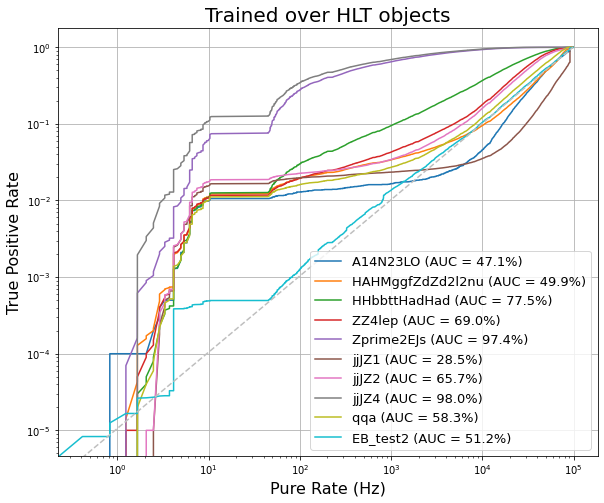

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


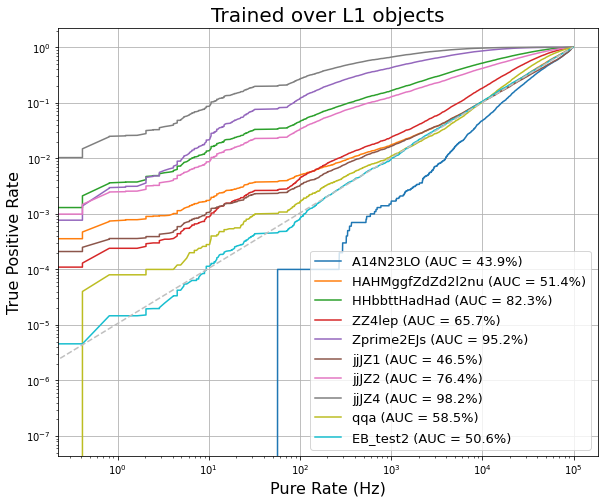

In [47]:
ROC_curve_3(datasets, bkg_type='HLT', target_rate=target_rate)
ROC_curve_3(datasets, bkg_type='L1', target_rate=target_rate)

### With Batch Norm at beginning

In [ ]:
HLT_TPRs, HLT_AUCs, HLT_thresholds = ROC_curve(datasets, bkg_type='HLT')
L1_TPRs, L1_AUCs, L1_thresholds = ROC_curve(datasets, bkg_type='L1')

In [ ]:
for data_tag in datasets.keys():
    if data_tag == 'EB_test1' or data_tag == 'EB_train': continue

    plt.figure(figsize=(14, 8))
    plt.rcParams['axes.linewidth'] = 2.4
    
    HLT_data = np.reshape(datasets[data_tag]['HLT_data'], newshape=(-1, 20, 3))
    sum_pt = np.sum(HLT_data[:, :, 0], axis=1)
    plt.hist2d(np.clip(datasets[data_tag]['HLT_AD_scores'],a_min=0, a_max=10000), np.clip(sum_pt, a_min=0, a_max=2000), bins=50, cmap='viridis', norm=matplotlib.colors.LogNorm(), weights=datasets[data_tag]['weights'])
    plt.colorbar()
    plt.plot([HLT_thresholds[data_tag], HLT_thresholds[data_tag]], [0, 2500], color='r', linewidth=3)
    plt.xlabel(f'AD score', fontsize=16)
    plt.ylabel(f'summed pt', fontsize=16)
    plt.title(f'{data_tag}: HLT pt vs AD score', fontsize=18)
    plt.show()

### Original

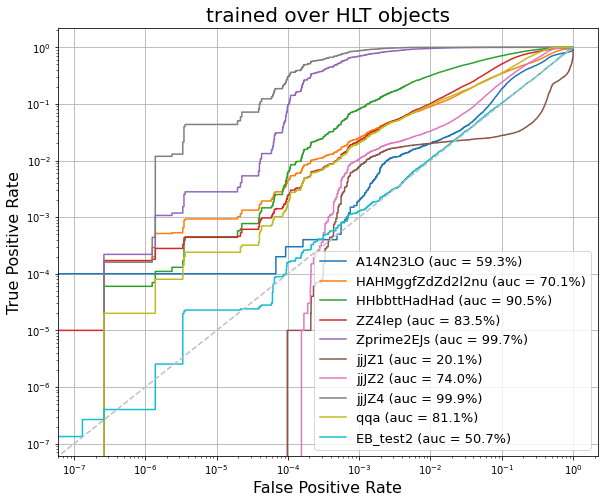

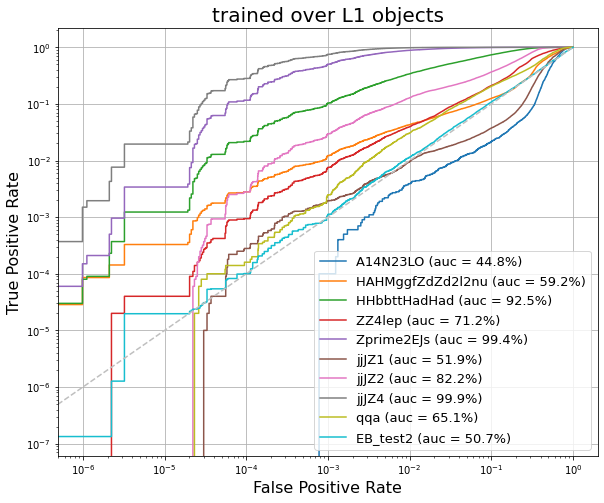

In [44]:
HLT_TPRs, HLT_AUCs, HLT_thresholds = ROC_curve(datasets, bkg_type='HLT')
L1_TPRs, L1_AUCs, L1_thresholds = ROC_curve(datasets, bkg_type='L1')

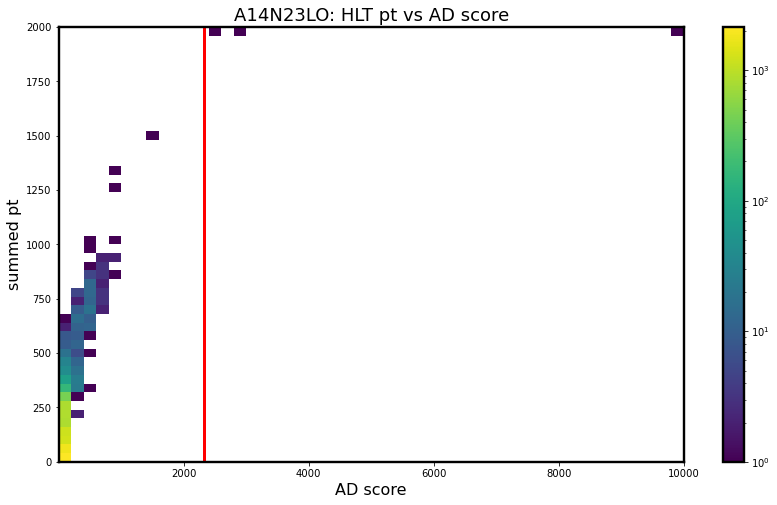

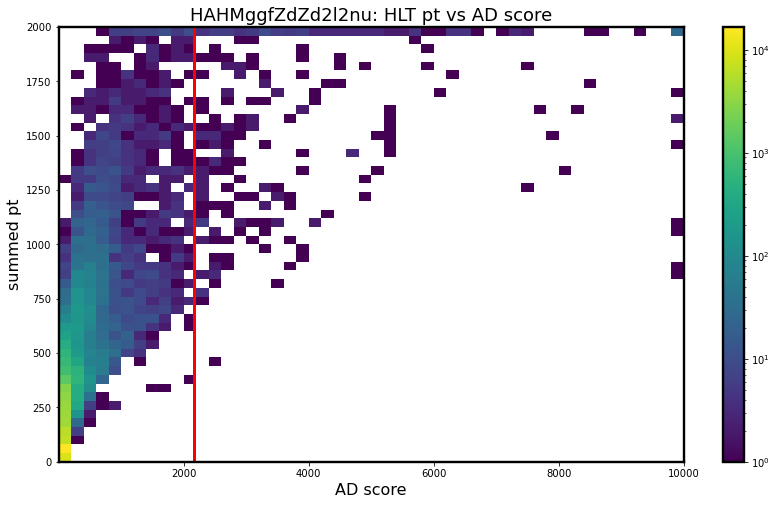

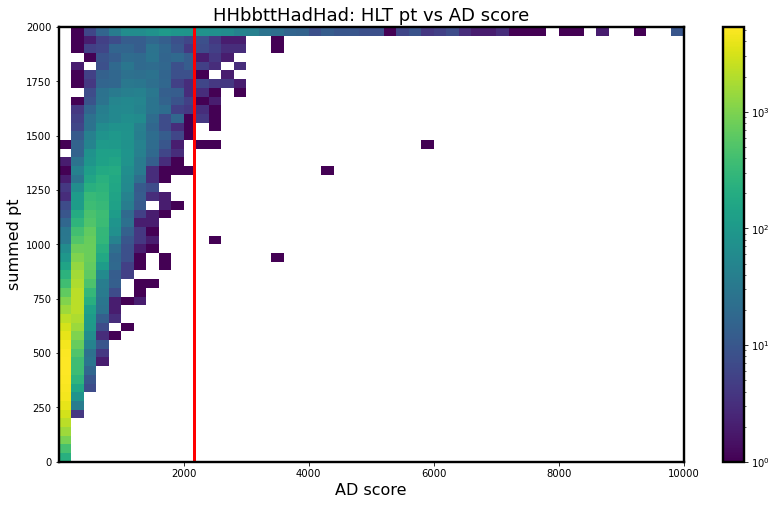

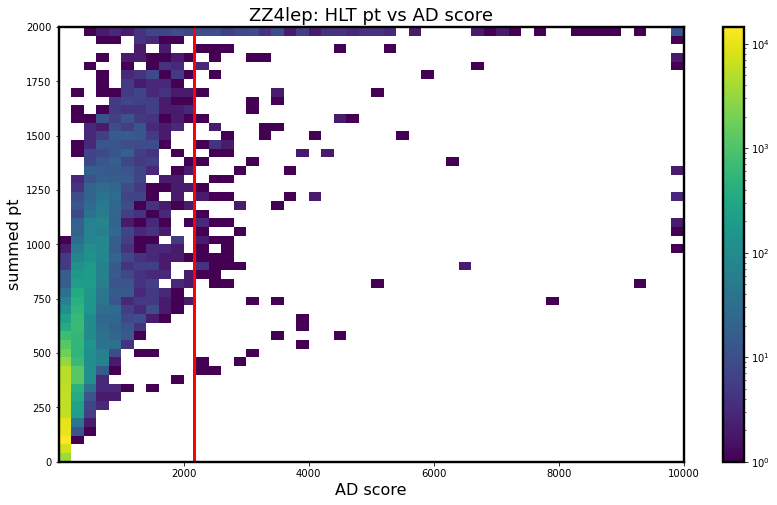

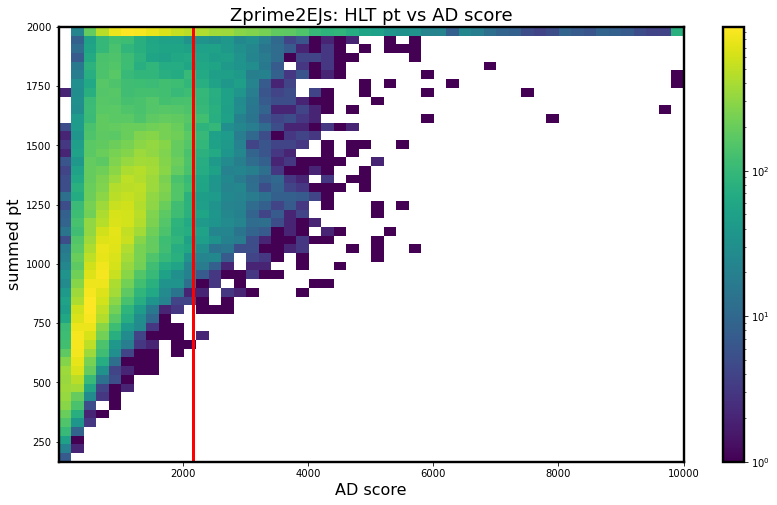

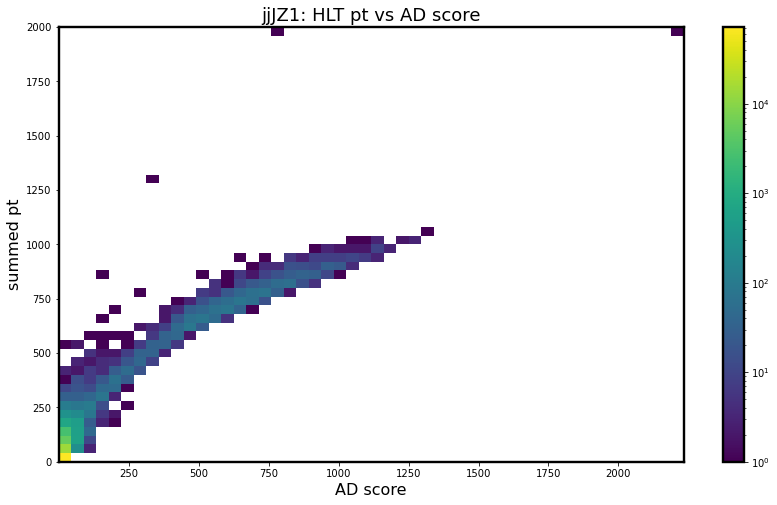

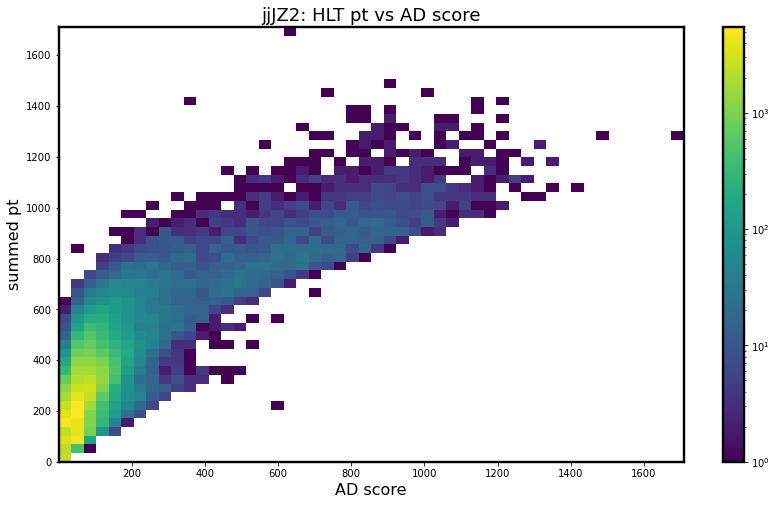

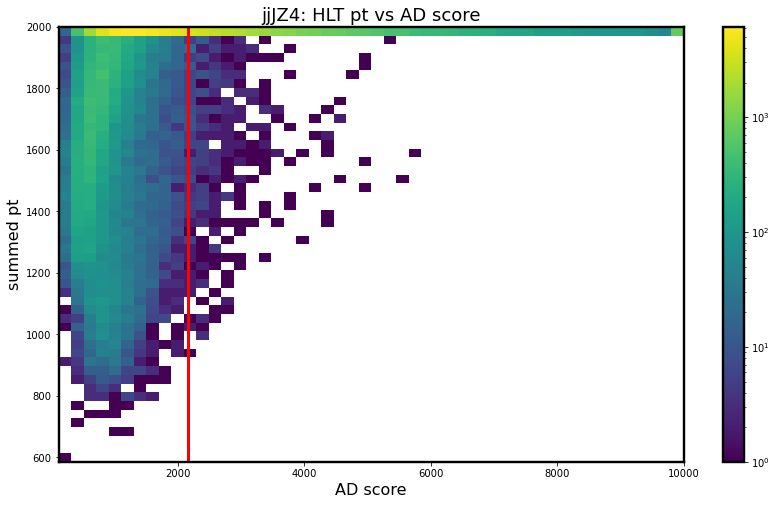

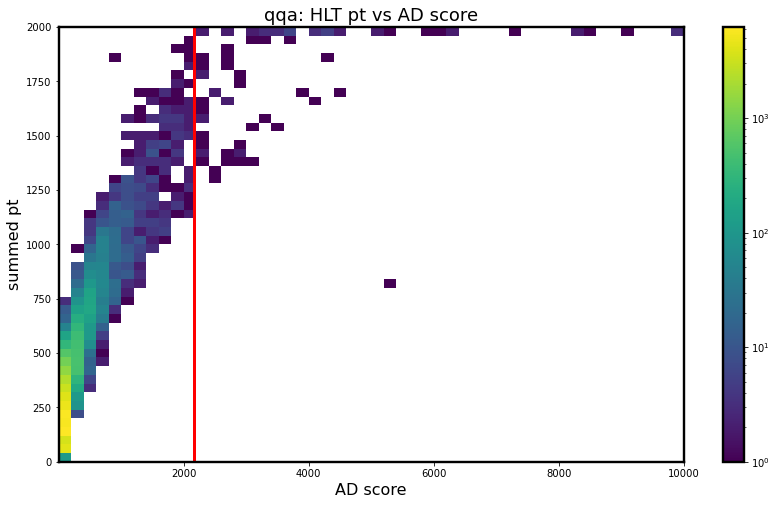

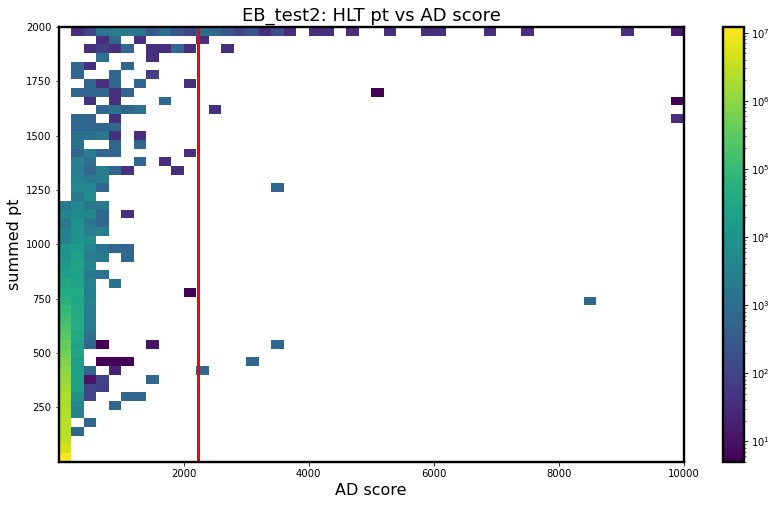

In [48]:
for data_tag in datasets.keys():
    if data_tag == 'EB_test1' or data_tag == 'EB_train': continue

    plt.figure(figsize=(14, 8))
    plt.rcParams['axes.linewidth'] = 2.4
    
    HLT_data = np.reshape(datasets[data_tag]['HLT_data'], newshape=(-1, 20, 3))
    sum_pt = np.sum(HLT_data[:, :, 0], axis=1)
    plt.hist2d(np.clip(datasets[data_tag]['HLT_AD_scores'],a_min=0, a_max=10000), np.clip(sum_pt, a_min=0, a_max=2000), bins=50, cmap='viridis', norm=matplotlib.colors.LogNorm(), weights=datasets[data_tag]['weights'])
    plt.colorbar()
    plt.plot([HLT_thresholds[data_tag], HLT_thresholds[data_tag]], [0, 2500], color='r', linewidth=3)
    plt.xlabel(f'AD score', fontsize=16)
    plt.ylabel(f'summed pt', fontsize=16)
    plt.title(f'{data_tag}: HLT pt vs AD score', fontsize=18)
    plt.show()

In [31]:
# Print HLT overlaps
print(f'MODEL THAT TRAINED OVER HLT OBJECTS::::::')

for tag, data in AD_scores.items():
    if tag.startswith('HLT') and tag != 'HLT_passedHLT':
        anomaly_idxs = data > HLT_threshold
        HLT_overlap = 0
        inverse_overlap = 0
        idx = 0
        for a, h in zip(anomaly_idxs, pass_HLT[tag]):
            if a==1 and h==1:
                HLT_overlap += weights[tag][idx]
            if a==1 or h==1:
                inverse_overlap += weights[tag][idx]
            idx += 1
    
        HLT_overlap /= np.sum(anomaly_idxs * weights[tag])
        inverse_overlap /= np.sum(pass_HLT[tag] * weights[tag])
    
        print(f'-----\n{tag}:')
        print(f'HLT overlap: {HLT_overlap}')
        print(f'inverse overlap: {inverse_overlap}')
        print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT[tag]) / len(pass_HLT[tag])}')
        print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
        print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER HLT OBJECTS::::::
-----
HLT_zerobias:
HLT overlap: 0.00014975945199250689
inverse overlap: 7.728444572115307
percentage of events that passed some HLT trigger: 0.0010400489555800105
percentage of events that we tagged as anomalous: 5.913751786981518e-05
number of events that we tagged as anomalous: 46
-----
HLT_Ztautau:
HLT overlap: 0.14043583535108958
inverse overlap: 1.0533273246207
percentage of events that passed some HLT trigger: 0.06657
percentage of events that we tagged as anomalous: 0.00413
number of events that we tagged as anomalous: 413
-----
HLT_ZZ4lep:
HLT overlap: 0.9362206689965052
inverse overlap: 1.0058614361091993
percentage of events that passed some HLT trigger: 0.8718
percentage of events that we tagged as anomalous: 0.08012
number of events that we tagged as anomalous: 8012
-----
HLT_qqa:
HLT overlap: 0.1518987341772152
inverse overlap: 1.1038299756475536
percentage of events that passed some HLT trigger: 0.09034
percentage of events that 

In [32]:
# Print L1 overlaps
print(f'MODEL THAT TRAINED OVER L1 OBJECTS::::::')

for tag, data in AD_scores.items():
    if tag.startswith('L1') and tag not in ['L1_passedHLT', 'L1_zerobias']:
        anomaly_idxs = data > L1_threshold
        HLT_overlap = 0
        inverse_overlap = 0
        idx = 0
        for a, h in zip(anomaly_idxs, pass_HLT[tag]):
            if a==1 and h==1:
                HLT_overlap += weights[tag][idx]
            if a==1 or h==1:
                inverse_overlap += weights[tag][idx]
            idx += 1
    
        HLT_overlap /= np.sum(anomaly_idxs * weights[tag])
        inverse_overlap /= np.sum(pass_HLT[tag] * weights[tag])
    
        print(f'-----\n{tag}:')
        print(f'HLT overlap: {HLT_overlap}')
        print(f'inverse overlap: {inverse_overlap}')
        print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT[tag]) / len(pass_HLT[tag])}')
        print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
        print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER L1 OBJECTS::::::
-----
L1_HHbbttHadHad:
HLT overlap: 1.0
inverse overlap: 1.0
percentage of events that passed some HLT trigger: 0.5459
percentage of events that we tagged as anomalous: 3e-05
number of events that we tagged as anomalous: 3
-----
L1_jjJZ4:
HLT overlap: 0.9285714285714286
inverse overlap: 1.0000101874490628
percentage of events that passed some HLT trigger: 0.9816
percentage of events that we tagged as anomalous: 0.00014
number of events that we tagged as anomalous: 14
-----
L1_jjJZ2:
HLT overlap: 0.0
inverse overlap: 1.0074766355140188
percentage of events that passed some HLT trigger: 0.0107
percentage of events that we tagged as anomalous: 8e-05
number of events that we tagged as anomalous: 8
-----
L1_test1:
HLT overlap: 0.0
inverse overlap: 1.0048423773076038
percentage of events that passed some HLT trigger: 0.032077277076593615
percentage of events that we tagged as anomalous: 9.112862805850458e-05
number of events that we tagged as anomalou

In [33]:
threshold = HLT_threshold

anomaly_idxs = (AD_scores['HLT_test2'] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
HLT_acceptance = np.sum(weights['HLT_test2'] * pass_HLT['HLT_test2']) / np.sum(weights['HLT_test2'])
HLT_AD_acceptance = np.sum(weights['HLT_test2'] * np.bitwise_or(anomaly_idxs, pass_HLT['HLT_test2'])) / np.sum(weights['HLT_test2'])

# Multiply by 100,000 since there are 100,000Hz going INTO the HLT
# HLT_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)
print(f'additional rate at 10e-4: {(HLT_AD_acceptance - HLT_acceptance) * 100000}')

additional rate at 10e-4: 10.050219915943432


In [48]:
HLT_rates = []
for i, fpr in enumerate(FPR['HLT_test2']):
    threshold = thresholds['HLT_test2'][i]
    
    anomaly_idxs = (AD_scores['HLT_test2'] > threshold) 
    HLT_acceptance = np.sum(weights['HLT_test2'] * pass_HLT['HLT_test2']) / np.sum(weights['HLT_test2'])
    HLT_AD_acceptance = np.sum(weights['HLT_test2'] * np.bitwise_or(anomaly_idxs, pass_HLT['HLT_test2'])) / np.sum(weights['HLT_test2'])
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    HLT_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f"progress: {i} / {len(FPR['HLT_test2'])}")

progress: 1 / 56819
progress: 10001 / 56819
progress: 20001 / 56819
progress: 30001 / 56819
progress: 40001 / 56819
progress: 50001 / 56819


In [49]:
L1_rates = []
for i, fpr in enumerate(FPR['L1_test2']):
    threshold = thresholds['L1_test2'][i]

    anomaly_idxs = (AD_scores['L1_test2'] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
    HLT_acceptance = np.sum(weights['L1_test2'] * pass_HLT['L1_test2']) / np.sum(weights['L1_test2'])
    HLT_AD_acceptance = np.sum(weights['L1_test2'] * np.bitwise_or(anomaly_idxs, pass_HLT['L1_test2'])) / np.sum(weights['L1_test2'])
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    L1_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f"progress: {i} / {len(FPR['L1_test2'])}")

progress: 1 / 56868
progress: 10001 / 56868
progress: 20001 / 56868
progress: 30001 / 56868
progress: 40001 / 56868
progress: 50001 / 56868


In [50]:
print(len(FPR['HLT_test2']))
      
print(len(HLT_rates))

56819
56819


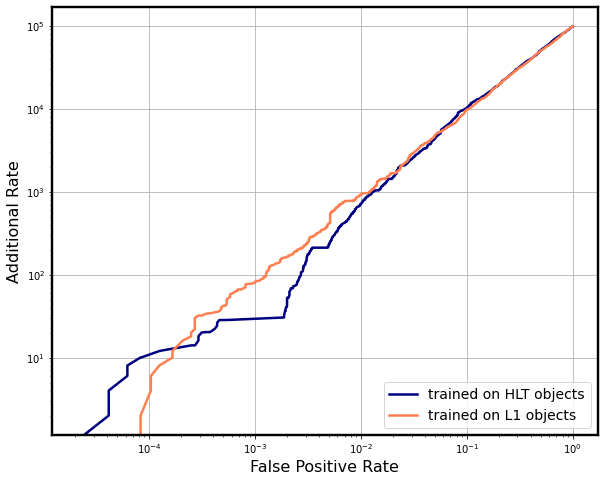

In [51]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(FPR['HLT_test2'], HLT_rates, color='navy', linewidth=2.5, label='trained on HLT objects')
plt.plot(FPR['L1_test2'], L1_rates, color='coral', linewidth=2.5, label='trained on L1 objects')

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

#plt.title('Trained over HLT Objects', fontsize=18)
plt.ylabel("Additional Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
plt.legend(loc='lower right', fontsize=14)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

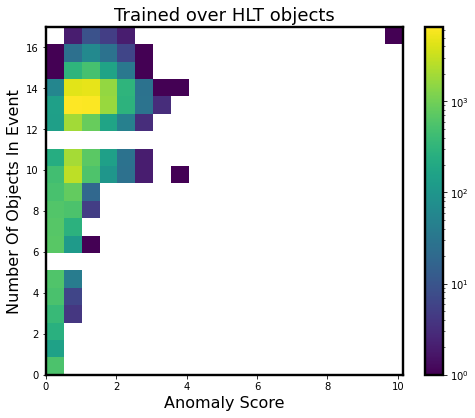

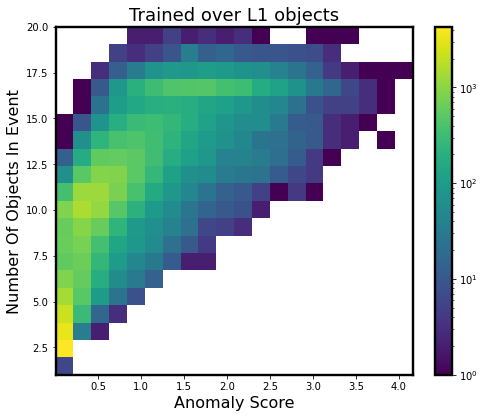

In [56]:
# Make a histogram of multiplicity vs anomaly score

HLT_pt_values = datasets['HLT_test2'].reshape(-1, 20, 3)[:, :, 0]
L1_pt_values = datasets['L1_test2'].reshape(-1, 20, 3)[:, :, 0]
HLT_num_objects = np.count_nonzero(HLT_pt_values, axis=1)
L1_num_objects = np.count_nonzero(L1_pt_values, axis=1)

plt.figure(figsize=(8, 6.4))
plt.rcParams['axes.linewidth'] = 2.4
plt.hist2d(AD_scores['HLT_test2'], HLT_num_objects, bins=20, cmap='viridis', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel(f'Anomaly Score', fontsize=16)
plt.ylabel(f'Number Of Objects In Event', fontsize=16)
plt.title('Trained over HLT objects', fontsize=18)
plt.show()

plt.figure(figsize=(8, 6.4))
plt.rcParams['axes.linewidth'] = 2.4
plt.hist2d(AD_scores['L1_test2'], L1_num_objects, bins=20, cmap='viridis', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel(f'Anomaly Score', fontsize=16)
plt.ylabel(f'Number Of Objects In Event', fontsize=16)
plt.title('Trained over L1 objects', fontsize=18)
plt.show()

In [39]:
# now I need to figure out, at some specific FPR, the overlap between HLT and the L1

In [40]:
HLT_anomaly_idxs = HLT_AD_scores[1] > HLT_threshold
L1_anomaly_idxs = L1_AD_scores[1] > L1_threshold

num_overlaps = np.sum(np.bitwise_and(HLT_anomaly_idxs, L1_anomaly_idxs))
num_HLT_anomalies = np.sum(HLT_anomaly_idxs)
num_L1_anomalies = np.sum(L1_anomaly_idxs)

# Calculate the fractions
f_HLT = (num_overlaps / num_HLT_anomalies)
f_L1 = (num_overlaps / num_L1_anomalies)

print(f'number of events that both the HLT and L1 models flagged as anomalous: {num_overlaps}')
print(f'out of the HLT anomalies, what fraction are also L1 anomalies? {f_HLT}')
print(f'out of the L1 anomalies, what fraction are also HLT anomalies? {f_L1}')

number of events that both the HLT and L1 models flagged as anomalous: 0
out of the HLT anomalies, what fraction are also L1 anomalies? 0.0
out of the L1 anomalies, what fraction are also HLT anomalies? 0.0


In [41]:
print(f'number of L1 anomalies: {num_L1_anomalies}')
print(f'number of HLT anomalies: {num_HLT_anomalies}')

number of L1 anomalies: 7
number of HLT anomalies: 8


In [76]:
# Let's take a closer look at these anomalies
HLT_anomalies = HLT_y_true[1][HLT_anomaly_idxs]
HLT_anom_outputs = HLT_model_outputs[1][HLT_anomaly_idxs]
L1_anomalies = L1_y_true[1][L1_anomaly_idxs]
L1_anom_outputs = L1_model_outputs[1][L1_anomaly_idxs]

print(f'Anomalies found by model trained on HLT objects:')
for i in range(len(HLT_anomalies)):
    print(f'event:\n{HLT_anomalies[i].reshape(-1, 20, 3)}')
    print(f'reconstruction:\n{HLT_anom_outputs[i].reshape(-1, 20, 3)}')

print(f'Anomalies found by model trained on L1 objects:')
for i in range(len(L1_anomalies)):
    print(f'event:\n{L1_anomalies[i].reshape(-1, 20, 3)}')
    print(f'reconstruction:\n{L1_anom_outputs[i].reshape(-1, 20, 3)}')

Anomalies found by model trained on HLT objects:
event:
[[[ 0.18945431  0.4822886  -0.30662119]
  [ 0.14006709  0.0747449   2.48758316]
  [ 0.10698286 -4.40890455  2.29233575]
  [ 0.10339661 -3.51014018 -0.84333491]
  [ 0.08084805  4.40199375 -2.6154201 ]
  [ 0.05505495  3.06775713 -2.3277216 ]
  [ 0.05356225  4.37638283  0.78126425]
  [ 0.04481367 -2.55221438 -0.62268186]
  [ 0.04245868  1.20024025  2.29764962]
  [ 0.03930756  2.72266507  3.05115509]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.06237572  0.03229186  2.51828933]
  [ 0.06237572  0.03229186  2.51828933]
  [ 0.01930252  0.49109831 -0.34072194]
  [ 0.          0.          0.        ]]]
reconstruction:
[[[ 0.07721651 -2.3509588   0.15923315]
  [ 0.09922105 -1.2720616   3.5524993 ]
  [ 0.08455377 -3.1708102  -0.55961454]
  [ 0.

In [42]:
# Print HLT overlaps
print(f'MODEL THAT TRAINED OVER HLT OBJECTS::::::')

for i, tag in enumerate(HLT_tags):
    anomaly_idxs = HLT_AD_scores[i] > HLT_threshold
    HLT_overlap = 0
    inverse_overlap = 0
    for a, h in zip(anomaly_idxs, pass_HLT_list[i]):
        if a==1 and h==1:
            HLT_overlap += 1
        if a==1 or h==1:
            inverse_overlap += 1

    HLT_overlap /= np.sum(anomaly_idxs)
    inverse_overlap /= np.sum(pass_HLT_list[i])

    print(f'-----\n{tag}:')
    print(f'HLT overlap: {HLT_overlap}')
    print(f'inverse overlap: {inverse_overlap}')
    print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT_list[i]) / len(pass_HLT_list[i])}')
    print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
    print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER HLT OBJECTS::::::
-----
data (background):
HLT overlap: 0.0
inverse overlap: 1.0028308563340411
percentage of events that passed some HLT trigger: 0.03197917845422655
percentage of events that we tagged as anomalous: 9.052845988457622e-05
number of events that we tagged as anomalous: 4
-----
HLT:
HLT overlap: 0.0
inverse overlap: 1.0056100981767182
percentage of events that passed some HLT trigger: 0.03266222313841362
percentage of events that we tagged as anomalous: 0.00018323827847637373
number of events that we tagged as anomalous: 8
-----
zerobias:
HLT overlap: 0.0
inverse overlap: 1.0469798657718121
percentage of events that passed some HLT trigger: 0.0009563236096402554
percentage of events that we tagged as anomalous: 4.492795481531401e-05
number of events that we tagged as anomalous: 7
-----
HHbbttHadHad:
HLT overlap: 0.5757575757575758
inverse overlap: 1.0038627793617216
percentage of events that passed some HLT trigger: 0.54365
percentage of events tha

In [43]:
# Print L1 overlaps
print(f'MODEL THAT TRAINED OVER L1 OBJECTS::::::')

for i, tag in enumerate(L1_tags):
    anomaly_idxs = L1_AD_scores[i] > L1_threshold
    HLT_overlap = 0
    inverse_overlap = 0
    for a, h in zip(anomaly_idxs, pass_HLT_list[i]):
        if a==1 and h==1:
            HLT_overlap += 1
        if a==1 or h==1:
            inverse_overlap += 1

    HLT_overlap /= np.sum(anomaly_idxs)
    inverse_overlap /= np.sum(pass_HLT_list[i])

    print(f'-----\n{tag}:')
    print(f'HLT overlap: {HLT_overlap}')
    print(f'inverse overlap: {inverse_overlap}')
    print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT_list[i]) / len(pass_HLT_list[i])}')
    print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
    print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER L1 OBJECTS::::::
-----
data (background):
HLT overlap: 0.2
inverse overlap: 1.0028308563340411
percentage of events that passed some HLT trigger: 0.03197917845422655
percentage of events that we tagged as anomalous: 0.00011316057485572027
number of events that we tagged as anomalous: 5
-----
L1 objects:
HLT overlap: 0.0
inverse overlap: 1.0049088359046283
percentage of events that passed some HLT trigger: 0.03266222313841362
percentage of events that we tagged as anomalous: 0.000160333493666827
number of events that we tagged as anomalous: 7
-----
zerobias:
HLT overlap: 0.0
inverse overlap: 1.0268456375838926
percentage of events that passed some HLT trigger: 0.0009563236096402554
percentage of events that we tagged as anomalous: 2.5673117037322294e-05
number of events that we tagged as anomalous: 4


In [65]:
HLT_rates = []
HLT_num_objects = []
for i, fpr in enumerate(HLT_fpr_loss):
    threshold = HLT_threshold_loss[i]

    anomaly_idxs = (HLT_AD_scores[1] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
    HLT_acceptance = np.sum(weights_list[1] * pass_HLT_list[1]) / np.sum(weights_list[1])
    HLT_AD_acceptance = np.sum(weights_list[1] * np.bitwise_or(anomaly_idxs, pass_HLT_list[1])) / np.sum(weights_list[1])

    pt_values = HLT_y_true[1][anomaly_idxs].reshape(-1, 20, 3)[:, :, 0]
    anom_weights = weights_list[1][anomaly_idxs]
    if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
    num_objects_per_event = np.count_nonzero(pt_values, axis=1)
    #HLT_num_objects.append(np.average(num_objects_per_event, weights=anom_weights))
    HLT_num_objects.append(np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    HLT_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f'progress: {i} / {len(HLT_fpr_loss)}')

/tmp/ipykernel_372/3218523813.py:15: RuntimeWarning: invalid value encountered in double_scalars
  HLT_num_objects.append(np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))


progress: 1 / 57940
progress: 10001 / 57940
progress: 20001 / 57940
progress: 30001 / 57940
progress: 40001 / 57940
progress: 50001 / 57940


In [66]:
L1_rates = []
L1_num_objects = []
for i, fpr in enumerate(L1_fpr_loss):
    threshold = L1_threshold_loss[i]

    anomaly_idxs = (L1_AD_scores[1] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
    HLT_acceptance = np.sum(weights_list[1] * pass_HLT_list[1]) / np.sum(weights_list[1])
    HLT_AD_acceptance = np.sum(weights_list[1] * np.bitwise_or(anomaly_idxs, pass_HLT_list[1])) / np.sum(weights_list[1])

    pt_values = L1_y_true[1][anomaly_idxs].reshape(-1, 20, 3)[:, :, 0]
    anom_weights = weights_list[1][anomaly_idxs]
    if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
    num_objects_per_event = np.count_nonzero(pt_values, axis=1)
    L1_num_objects.append(np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    L1_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f'progress: {i} / {len(L1_fpr_loss)}')

progress: 1 / 127979
progress: 10001 / 127979
progress: 20001 / 127979
progress: 30001 / 127979
progress: 40001 / 127979
progress: 50001 / 127979
progress: 60001 / 127979
progress: 70001 / 127979
progress: 80001 / 127979
progress: 90001 / 127979
progress: 100001 / 127979
progress: 110001 / 127979
progress: 120001 / 127979


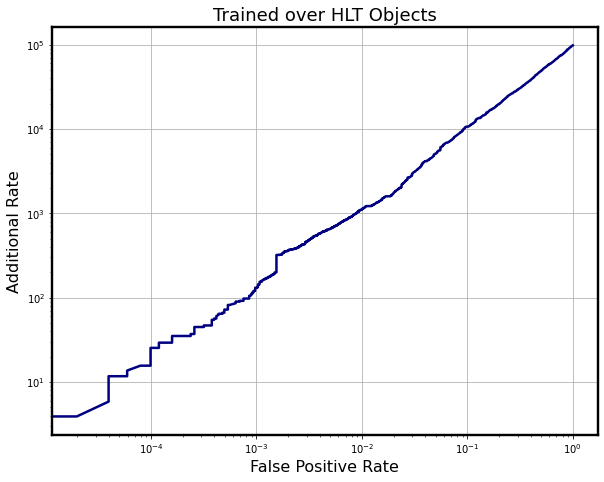

In [67]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(HLT_fpr_loss, HLT_rates, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

plt.title('Trained over HLT Objects', fontsize=18)
plt.ylabel("Additional Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

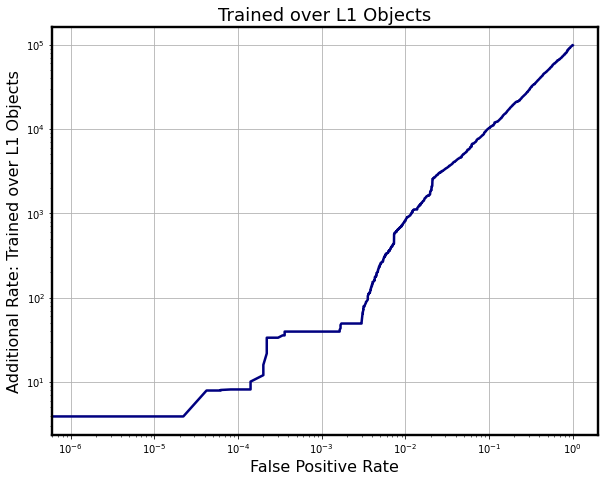

In [68]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(L1_fpr_loss, L1_rates, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

plt.title('Trained over L1 Objects', fontsize=18)
plt.ylabel("Additional Rate: Trained over L1 Objects", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

In [69]:
target_fpr = 10**-4
HLT_idx = np.argmin(np.abs(HLT_fpr_loss - target_fpr))
L1_idx = np.argmin(np.abs(L1_fpr_loss - target_fpr))

print(f'Pure rate at fpr=10e-4: {HLT_rates[HLT_idx]} (trained over HLT objects)')
print(f'Pure rate at fpr=10e-4: {L1_rates[L1_idx]} (trained over L1 objects)')

Pure rate at fpr=10e-4: 15.612964742042074 (trained over HLT objects)
Pure rate at fpr=10e-4: 8.156675357946785 (trained over L1 objects)


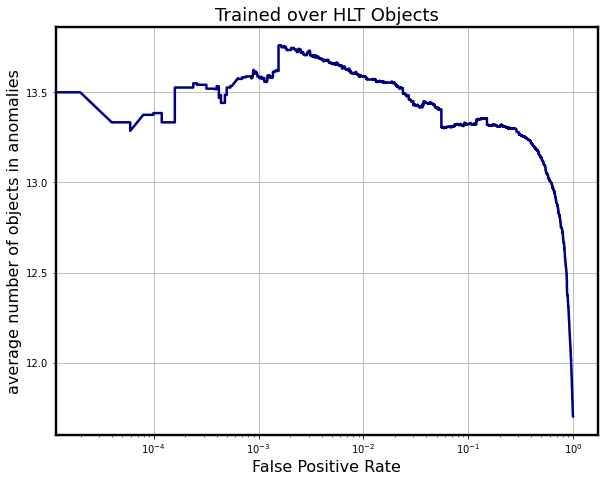

In [72]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(HLT_fpr_loss, HLT_num_objects, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
#plt.semilogy()

plt.title('Trained over HLT Objects', fontsize=18)
plt.ylabel("average number of objects in anomalies", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

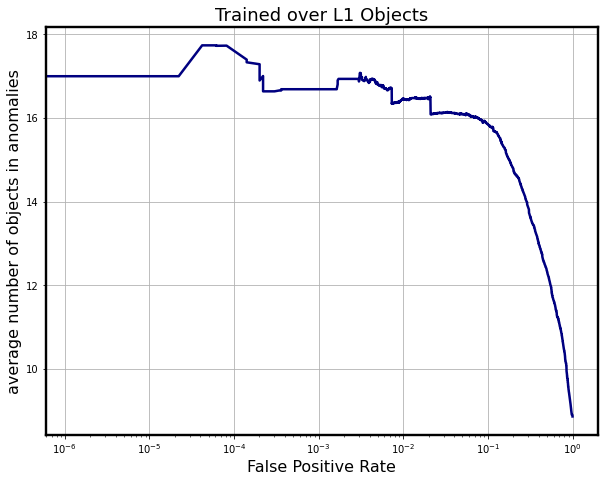

In [73]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(L1_fpr_loss, L1_num_objects, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
#plt.semilogy()

plt.title('Trained over L1 Objects', fontsize=18)
plt.ylabel("average number of objects in anomalies", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

In [74]:
pt_values = HLT_y_true[1].reshape(-1, 20, 3)[:, :, 0]
anom_weights = weights_list[1]
if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
num_objects_per_event = np.count_nonzero(pt_values, axis=1)
HLT_num_objs = (np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
print(f'average number of objects per event in the whole test data with HLT objects: {HLT_num_objs}')

average number of objects per event in the whole test data with HLT objects: 11.692775578449224


In [75]:
pt_values = L1_y_true[1].reshape(-1, 20, 3)[:, :, 0]
anom_weights = weights_list[1]
if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
num_objects_per_event = np.count_nonzero(pt_values, axis=1)
L1_num_objs = (np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
print(f'average number of objects per event in the whole test data with L1 objects: {L1_num_objs}')

average number of objects per event in the whole test data with L1 objects: 8.855968094629004
